## Importar librerías

In [736]:
import pandas as pd
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import spacy 
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

## Data Cleanning

In [737]:
friends = pd.read_csv("friends_quotes.csv")

In [738]:
chandler =["CHAN","CHANDLER","Chandler (Stands up and walks to Joey)","Chandle","Chandler (nearly weeping)","Chandler (to Joey)", "Chandler (to Monica)", "Chandlers"]
monica =["Young Monica","Fake Monica", "Fat Monica", "MONICA","MNCA","MOnica","Monic","Monica (to Ross)","Monica about to have a heart attack","Monica to Amy","Monica to Emma","Monica to Ross","Monica (reads a form in her lap)"] 
joey = ["Fat Joey","JOEY","Joe","Joey (staring at the cake)","Joey (to Rachel)","Joey (to Ross)"]
phoebe = ["PHOE","PHOEBE","Phoeb","Phoebe (to Mike)","Phoebe (to Rachel)","Phoebe (walking to Ross carrying a black leather jacket)","Phoebe (watching the food on the table)","Phoebe looks down"]
rachel = ["RACH","RACHEL","RAHCEL", "Rache","Rachel (crying)","Rachel (leaving)","Rachel (on the phone)","Rachel (she flips the coin)","Rachel opens their door","Rachel to Emma","Rachel (as Monica)","Racel"]
ross = ["ROSS","Ross (on the verge of tears)","Ross (stops recording)","Ross (to Emma)","Ross first has a look of 'huh' then changes it to sarcastic happy","Ross looks down","Ross makes some sort of sound to let us know it hurt","Ross starts playing with a plate","Ross starts talking over her 'do you remember' line","Ross to Monica","Ross with a look of wondering how long this is going to go on on his face","Young Ross","ros"]

In [739]:
friends["author"] = friends["author"].apply(lambda x: "Chandler" if x in chandler else x).apply(lambda x: "Phoebe" if x in phoebe else x).apply(lambda x: "Joey" if x in joey else x).apply(lambda x: "Rachel" if x in rachel else x).apply(lambda x: "Ross" if x in ross else x).apply(lambda x: "Monica" if x in monica else x).str.strip().str.lower().str.replace("ms. geller","mrs. geller").str.capitalize()

In [740]:
friends["author"].value_counts().head(13)

Rachel      9129
Ross        8932
Monica      8339
Chandler    8319
Joey        8048
Phoebe      7384
Mike         351
All          330
Richard      256
Janice       214
Charlie      190
Carol        187
Emily        160
Name: author, dtype: int64

In [741]:
more_common_characters = friends["author"].value_counts().head(13).index.to_list()

In [742]:
friends[friends["author"]=="Mike"]["season"].value_counts()# we need to delete the mikes from season 3 and 4  

9.0     229
10.0    115
4.0       4
3.0       3
Name: season, dtype: int64

In [743]:
friends[friends["author"]=="Richard"]["season"].value_counts() # we need to delete the Richard from season 7

2.0    128
6.0     50
3.0     43
7.0     35
Name: season, dtype: int64

In [744]:
more_common_characters.remove("All")

In [745]:
friends.drop(friends[(friends["author"] == "Mike") & (friends["season"].isin(["3.0","4.0"]))].index,inplace = True)

In [746]:
friends[friends["author"]=="Mike"]["season"].value_counts()

9.0     229
10.0    115
Name: season, dtype: int64

In [747]:
friends.drop(friends[(friends["author"] == "Richard") & (friends["season"].isin(["7.0"]))].index,inplace = True)

In [748]:
friends[friends["author"]=="Richard"]["season"].value_counts()

2.0    128
6.0     50
3.0     43
Name: season, dtype: int64

In [749]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,9)

<AxesSubplot:xlabel='count', ylabel='author'>

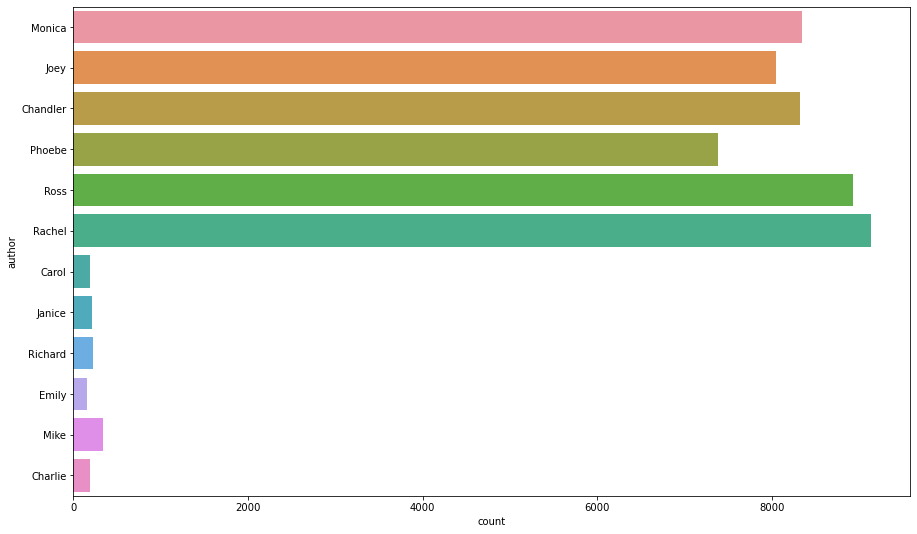

In [750]:
sns.countplot(y='author', data=friends[friends.author.isin(more_common_characters)])

In [751]:
new_df = friends[friends["author"].isin(more_common_characters)]
new_df

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
...,...,...,...,...,...,...
60286,Chandler,17.0,"The Last One, Part I & II","Oh, it's gonna be okay.",581.0,10.0
60287,Rachel,17.0,"The Last One, Part I & II",(crying) Do you guys have to go to the new hou...,582.0,10.0
60288,Monica,17.0,"The Last One, Part I & II",We got some time.,583.0,10.0
60289,Rachel,17.0,"The Last One, Part I & II","Okay, should we get some coffee?",584.0,10.0


In [752]:
new_df.to_excel(r"./all.xlsx", index = False)

In [753]:
episode1_12 = pd.read_excel("all_modified.xlsx")

In [754]:
conversation = list(episode1_12["Conversation"].unique())
conversation

['All',
 'The boys',
 'Monica, Rachel, Chandler, Joey',
 'Rachel, Monica',
 'Monica & Rachel & Ross',
 'Ross, Carol',
 'Ross, Rachel',
 'Chandler, Joey',
 'The girls',
 'Monica, Joey',
 'Ross, Chandler',
 'Chandler, Phoebe',
 'Chandler, Janice',
 'Chandler, Monica',
 'Ross, Joey',
 'Monica, Joey & Phoebe',
 'Phoebe, Monica',
 'Phoebe, Rachel']

In [755]:
for i in ["All","The boys","Monica, Rachel, Chandler, Joey","Monica & Rachel & Ross","The girls","Monica, Joey & Phoebe"]:
    conversation.remove(i)

In [756]:
conversation_weights = episode1_12[episode1_12["Conversation"].isin(conversation)]["Conversation"].value_counts(normalize = True)
conversation_weights

Ross, Rachel        0.222672
Ross, Carol         0.161943
Chandler, Joey      0.121457
Monica, Joey        0.109312
Phoebe, Rachel      0.076923
Phoebe, Monica      0.066802
Ross, Joey          0.066802
Chandler, Phoebe    0.048583
Ross, Chandler      0.040486
Chandler, Janice    0.036437
Rachel, Monica      0.024291
Chandler, Monica    0.024291
Name: Conversation, dtype: float64

In [757]:
import networkx as nx

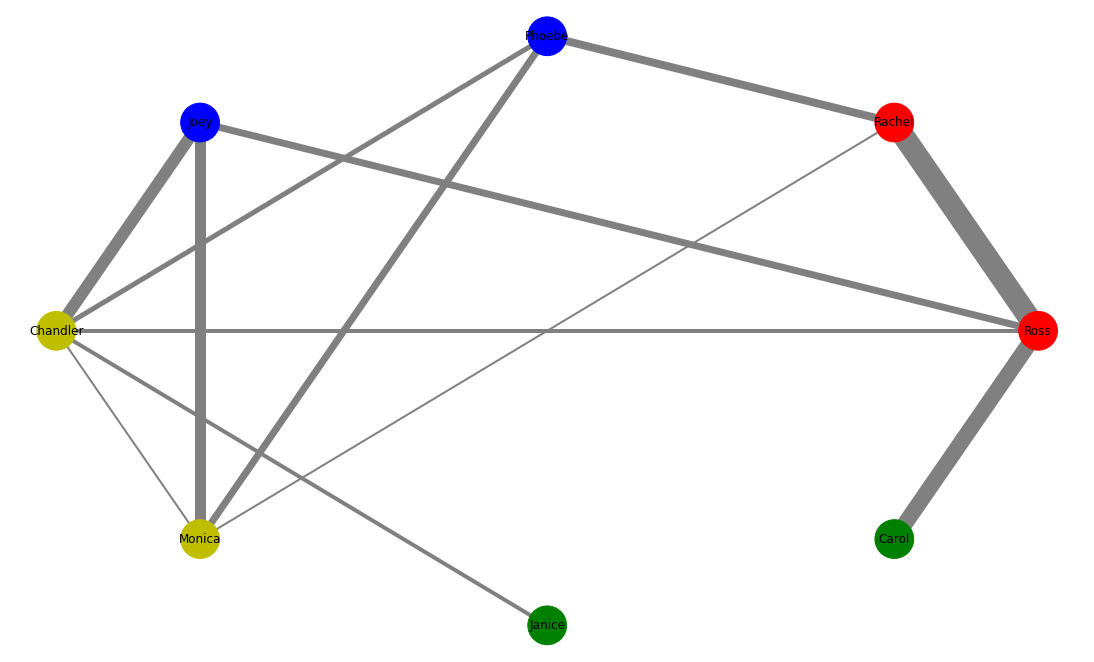

In [758]:
G = nx.Graph()
G.add_node("Ross", color='r')
G.add_node("Rachel", color='r')
G.add_node("Phoebe", color='b')
G.add_node("Joey", color='b')
G.add_node("Chandler", color='y')
G.add_node("Monica", color='y')
G.add_node("Janice", color='g')
G.add_node("Carol", color='g')

G.add_edge("Ross","Rachel", weight=round(conversation_weights[0]*100))
G.add_edge("Ross","Carol",weight=round(conversation_weights[1]*100))
G.add_edge("Chandler","Joey",weight=round(conversation_weights[2]*100))
G.add_edge("Monica","Joey", weight=round(conversation_weights[3]*100))
G.add_edge("Phoebe","Rachel", weight=round(conversation_weights[4]*100))
G.add_edge("Phoebe","Monica", weight=round(conversation_weights[5]*100))
G.add_edge("Ross","Joey", weight=round(conversation_weights[6]*100))
G.add_edge("Phoebe","Chandler", weight=round(conversation_weights[7]*100))
G.add_edge("Chandler","Ross", weight=round(conversation_weights[8]*100))
G.add_edge("Chandler","Janice", weight=round(conversation_weights[9]*100))
G.add_edge("Monica","Rachel", weight=round(conversation_weights[10]*100))
G.add_edge("Chandler","Monica", weight=round(conversation_weights[11]*100))


colors_nodes = nx.get_node_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()

pos = nx.circular_layout(G)
nx.draw(G, pos, 
        edge_color="grey", 
        width=list(weights),
        with_labels=True,
        node_color= colors_nodes, node_size=1500)

In [759]:
main_characters = ["Ross", "Joey","Chandler","Phoebe","Rachel","Monica"]

In [760]:
episode1_12= episode1_12.drop(columns=['episode_number', 'episode_title', "quote_order"]).reset_index(drop = True)
episode1_12

,author,quote,season,To Whom,Conversation
0,Monica,There's nothing to tell! He's just some guy I ...,1,All,All
1,Joey,"C'mon, you're going out with the guy! There's ...",1,All,All
2,Chandler,"All right Joey, be nice. So does he have a hum...",1,All,All
3,Phoebe,"Wait, does he eat chalk?",1,All,All
4,Phoebe,"Just, 'cause, I don't want her to go through w...",1,All,All
...,...,...,...,...,...
2103,Joey,"Uh, it's 2:30 in the morning!",1,All,All
2104,Chandler,"Yeah, get out!",1,All,All
2105,Monica,You guys are always hanging out in my apartmen...,1,All,All
2106,Chandler,(to Joey) One more game?,1,All,All


In [761]:
episode1_12["quote"] = episode1_12["quote"].str.replace("\(([^)]+)\)","").str.strip().str.lower().str.split("[.|!|?]", expand = False)
episode1_12["quote"]

0       [there's nothing to tell,  he's just some guy ...
1       [c'mon, you're going out with the guy,  there'...
2       [all right joey, be nice,  so does he have a h...
3                             [wait, does he eat chalk, ]
4       [just, 'cause, i don't want her to go through ...
                              ...                        
2103                     [uh, it's 2:30 in the morning, ]
2104                                    [yeah, get out, ]
2105    [you guys are always hanging out in my apartme...
2106                                    [one more game, ]
2107                                          [oh yeah, ]
Name: quote, Length: 2108, dtype: object

In [762]:
episode1_12 = episode1_12.explode("quote")

In [763]:
episode1_12.reset_index(drop = True, inplace = True)

In [764]:
scene = episode1_12[episode1_12["quote"].str.contains("scene:")].index.to_list()
scene

[150, 410]

In [765]:
episode1_12 = episode1_12.drop(episode1_12.index[scene])

In [766]:
episode1_12["quote"] = episode1_12["quote"].str.replace("[^a-zA-Z' ]","")

In [767]:
episode1_12.reset_index(drop = True, inplace = True)

In [768]:
indexes = []
for i in range(len(episode1_12["quote"])):
    if len(episode1_12["quote"][i]) == 0:
        indexes.append(i)

In [769]:
episode1_12 = episode1_12.drop(episode1_12.index[indexes]).reset_index(drop = True)

In [770]:
episode1_12["quote"] = episode1_12["quote"].str.strip()

In [771]:
episode1_12['number_words'] = episode1_12['quote'].str.count(' ') + 1

In [772]:
one_word = episode1_12[episode1_12["number_words"] == 1].index.to_list()

In [773]:
episode1_12 = episode1_12.drop(episode1_12.index[one_word]).reset_index(drop = True)

In [774]:
episode1_12["quote"].value_counts()

oh my god                             17
thank you                              8
i know                                 8
oh no                                  7
oh god                                 6
                                      ..
you know what the scariest part is     1
are these the shoes                    1
how'd you get to that                  1
she's gonna break the pact             1
i need to borrow some moisturizer      1
Name: quote, Length: 2879, dtype: int64

In [775]:
episode1_12["quote"] = episode1_12["quote"].str.replace("'\s","")

In [776]:
episode1_12["quote"] = episode1_12["quote"].str.replace("'cause","because").str.replace("you know","y'know").str.replace("you are","you're").str.replace("come on","c'mon").str.replace("'kay","okay").str.replace("'em","them").str.replace("doin'","doing").str.replace("(ya)","you").str.replace("lemme","let me").str.replace("gonna", "going to").str.replace("'", "")

In [777]:
episode1_12.drop('number_words', axis='columns', inplace=True)

## CountVectorizer (most spoken words by two people)

In [778]:
vectorizer = CountVectorizer(ngram_range =(3,3))

matrix = vectorizer.fit_transform(episode1_12["quote"])
matrix

<3039x11968 sparse matrix of type '<class 'numpy.int64'>'
	with 13051 stored elements in Compressed Sparse Row format>

In [779]:
y = episode1_12.iloc[:, 4].values

In [780]:
counts = pd.DataFrame(matrix.toarray(),index = list(y),
                      columns=vectorizer.get_feature_names())
counts = counts.groupby(counts.index).sum()

In [781]:
counts.T.columns

Index(['All', 'Chandler, Janice', 'Chandler, Joey', 'Chandler, Monica',
       'Chandler, Phoebe', 'Monica & Rachel & Ross', 'Monica, Joey',
       'Monica, Joey & Phoebe', 'Monica, Rachel, Chandler, Joey',
       'Phoebe, Monica', 'Phoebe, Rachel', 'Rachel, Monica', 'Ross, Carol',
       'Ross, Chandler', 'Ross, Joey', 'Ross, Rachel', 'The boys',
       'The girls'],
      dtype='object')

In [782]:
counts.T["Chandler, Janice"].sort_values(ascending = False).head(15)

you can wear           2
im looking im          2
its just my            2
it stop it             2
just my lens           2
oh my god              2
stop it stop           2
looking im looking     2
can wear rocky         1
can wear bullwinkle    1
the thing janice       1
im going to            1
mix and match          1
or you can             1
rocky and rockyor      1
Name: Chandler, Janice, dtype: int64

## TfidfVectorizer (most spoken words by two people)

In [783]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range =(3,3))

In [784]:
X = tfidf.fit_transform(episode1_12["quote"])
y = episode1_12.iloc[:, 4].values

In [785]:
counts2 = pd.DataFrame(X.toarray(),index = list(y),
                      columns=tfidf.get_feature_names())
counts2 = counts2.groupby(counts2.index).sum()

In [786]:
counts2.T["Chandler, Janice"].sort_values(ascending = False).head(15)

its just my          1.274611
just my lens         1.274611
are you ok           1.000000
thats so sweet       1.000000
whatever you want    1.000000
well there you       0.737122
thats not good       0.724527
the thing janice     0.724527
ill be right         0.724527
it stop it           0.707107
stop it stop         0.707107
heres the thing      0.689246
hey thats not        0.689246
be right back        0.689246
there you go         0.675760
Name: Chandler, Janice, dtype: float64